<a href="https://colab.research.google.com/github/haysho2260/466finalProject/blob/main/KNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
import pandas as pd
import zipfile
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

## Cleaning the Dataset

This is getting the dataset from Pablo Deplon's github.

In [2]:
df_features = pd.read_csv('https://media.githubusercontent.com/media/PabloBelloDelpon/Spotify_paper/master/spotify_features_data.csv', delimiter='\t')
df_features["date"] = df_features["date"].str.split("-").str[0]
df_features.columns
df_features.rename(columns={"country": "Country", "date":"Year"}, inplace=True)
df_feat_grouped = df_features.groupby(["Country", "Year"])[["track_danceability", "track_energy",
  "track_key", "track_loudness", "track_mode", "track_speechiness",
  "track_acousticness", "track_instrumentalness", "track_liveness",
  "track_valence", "track_tempo", "track_duration_ms"]].mean()
df_feat_grouped.reset_index(inplace=True)

In [3]:
# response = requests.get("https://github.com/PabloBelloDelpon/Spotify_paper/raw/master/itunes_data.csv.zip")
# with zipfile.ZipFile(BytesIO(response.content)) as z:
#   # Extract the CSV file
#   csv_filename = z.namelist()[0]
#   with z.open(csv_filename) as f:
#       # Read the CSV file into a DataFrame
#       df_itunes = pd.read_csv(f)
# df_itunes

In [4]:
# response = requests.get("https://github.com/PabloBelloDelpon/Spotify_paper/raw/master/spotify_data.csv.zip")
# with zipfile.ZipFile(BytesIO(response.content)) as z:
#   # Extract the CSV file
#   csv_filename = z.namelist()[0]
#   with z.open(csv_filename) as f:
#       # Read the CSV file into a DataFrame
#       df_spotify = pd.read_csv(f)
# df_spotify = df_spotify[["country", "date", "artist", "track_id"]]

This is getting the dataset that I uploaded to Github from the World Bank.

In [ ]:
df_gdp = pd.read_csv("https://github.com/haysho2260/466finalProject/raw/main/gdp_dataset.csv")
years = ["2017", "2018", "2019", "2020"]
df_gdp_stac = pd.DataFrame()
for y in years:
  print()
  temp = df_gdp[["Country Name", y]]
  temp.rename(columns={y: "GDP", "Country Name": "Country"}, inplace=True)
  temp["Year"] = y
  df_gdp_stac = df_gdp_stac.append (temp, ignore_index=True)

This merges the gdp into the main music features dataset.

In [6]:
df_merged = df_feat_grouped.merge(df_gdp_stac, on=["Country", "Year"], how="inner")


## Finding the best features for KNN



Initially we are training the model with the full dataset

In [7]:
X_train = df_merged[["track_danceability", "track_energy",
  "track_key", "track_loudness", "track_mode", "track_speechiness",
  "track_acousticness", "track_instrumentalness", "track_liveness",
  "track_valence", "track_tempo", "track_duration_ms"]]
y_train = df_merged["GDP"]

Make a powerset to make all the possible song features

In [8]:
from itertools import chain, combinations

def powerset(iterable):
    features = list(iterable)
    return chain.from_iterable(combinations(features, r) for r in range(len(features)+1))

song_features = ["track_danceability", "track_energy",
  "track_key", "track_loudness", "track_mode", "track_speechiness",
  "track_acousticness", "track_instrumentalness", "track_liveness",
  "track_valence", "track_tempo", "track_duration_ms"]

# Gets all possible combinations of song features
reg_power_set = []
for subset in powerset(song_features):
    reg_power_set.append(list(subset))

reg_power_set = reg_power_set[1:]

Run Code to Find the Features that Produce the Lowest MSE in relation to the GDP

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

# define function to calculate estimate of test error for a given feature set
def get_cv_error(features, merged_df, X_train, y_train):

  ct = make_column_transformer(
      (StandardScaler(), features),
      remainder="drop"
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=5)
  )
  # errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_train[features],
                             y=y_train,
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in reg_power_set:
  errs[str(features)] = get_cv_error(features, df_merged, X_train, y_train)


Look at the first of the errors with the smallest value. This will give use the set that results in the most valuable features to look at

In [ ]:
errs.sort_values()

In [32]:
best_features = ['track_energy', 'track_key', 'track_loudness', 'track_mode', 'track_speechiness', 'track_liveness', 'track_valence', 'track_tempo', 'track_duration_ms']
len(best_features)

9

Find the best k value for nearest neighbors. Make a pipeline to put into gridsearch.

In [25]:
ct = make_column_transformer(
    (StandardScaler(), best_features),
    remainder="drop"
)
pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=5)
)

In [30]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline,
    param_grid={
        "kneighborsregressor__n_neighbors": range(1, 13)
    },
    scoring="neg_mean_squared_error",
    cv=3)
grid_search.fit(X_train[best_features], y_train)
grid_search.best_estimator_


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['track_energy', 'track_key',
                                                   'track_loudness',
                                                   'track_mode',
                                                   'track_speechiness',
                                                   'track_liveness',
                                                   'track_valence',
                                                   'track_tempo',
                                                   'track_duration_ms'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=6))])

<Axes: title={'center': 'kNN models with 9 features'}, xlabel='k', ylabel='test error'>

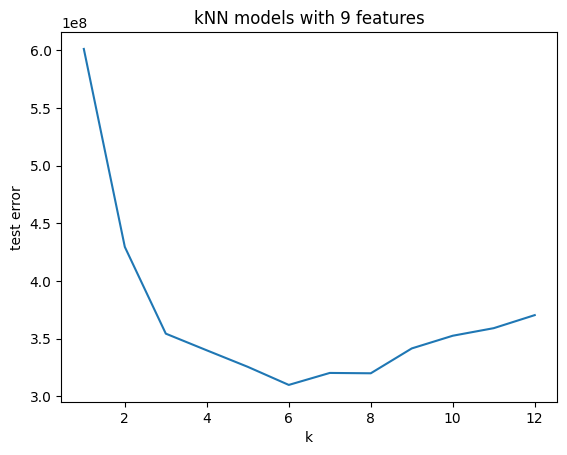

In [33]:
df_cv_results_ = pd.DataFrame(grid_search.cv_results_)
df_cv_results_["param_kneighborsregressor__n_neighbors"] = df_cv_results_["param_kneighborsregressor__n_neighbors"].astype(int)
df_cv_results_.set_index("param_kneighborsregressor__n_neighbors", inplace = True)
(-df_cv_results_["mean_test_score"]).plot.line(xlabel = "k", ylabel = "test error", title = "kNN models with 9 features")

The best number of neighbors is 6.

## Training the Model

Define the test and training set with the best features

In [44]:
best_features = ['track_energy', 'track_key', 'track_loudness', 'track_mode', 'track_speechiness', 'track_liveness', 'track_valence', 'track_tempo', 'track_duration_ms']
k = 6

X_train = df_merged[df_merged["Year"] != "2020"][best_features]
X_test = df_merged[df_merged["Year"] == "2020"][best_features]
y_train = df_merged[df_merged["Year"] != "2020"]["GDP"]
y_test = df_merged[df_merged["Year"] == "2020"]["GDP"]


In [54]:
y_train

0      14613.035649
1      11795.162745
2       9963.674162
4      53954.553495
5      57273.520475
           ...     
177    62823.309438
178    65120.394663
180    18995.397020
181    19026.049817
182    18098.361549
Name: GDP, Length: 138, dtype: float64

Fit the KNN model to the features

In [45]:
ct = make_column_transformer(
    (StandardScaler(), best_features),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=k)
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['track_energy', 'track_key',
                                                   'track_loudness',
                                                   'track_mode',
                                                   'track_speechiness',
                                                   'track_liveness',
                                                   'track_valence',
                                                   'track_tempo',
                                                   'track_duration_ms'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=6))])

Cross Validate the pipeline

In [47]:
scores = -cross_val_score(pipeline,
                         X_train,
                         y_train,
                         scoring="neg_root_mean_squared_error",
                         cv=5)
scores.mean()

17840.01854456281

Benchmark

In [48]:
y_train.std()

24142.88680878906

In comparison to the benchmark, the cross validation pipeline did considerably better.

## Comparing to the test set

In [55]:
y_prediction = pipeline.predict(X_test)

In [57]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_prediction))
rmse

20179.28006515973

In [58]:
y_test.std()

24095.638492192124

In comparison to the test set, our prediction model does not do significantly better than the standard deviation in predicting the GDP.